<a href="https://colab.research.google.com/github/jjavy/MCDAA/blob/main/Tarea_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agrupamiento

Para la presente, se seleccionó el uso del algoritmo **DBSCAN** *(Density-Based Spatial Clustering of Applications with Noise)* para usar en el código.

DBSCAN agrupa puntos que están densamente conectados en el espacio de características y etiqueta como ruido los puntos en zonas de baja densidad.

* Un punto `p` es core si su vecindad `N_eps(p)` contiene al menos `min_samples`.
* Dos puntos están directamente conectados por densidad si uno está dentro del `eps` del otro y al menos uno es core.
* La conectividad por densidad extiende esto transitivamente y define clusters como componentes conectadas por densidad.
* Los puntos que no pertenecen a ningún cluster se marcan -1 (ruido).

Donde,

`eps` — radio de vecindad.

`min_samples` — número mínimo de puntos dentro de eps para considerar un punto core.

**Ventajas**

* No se necesita fijar k (número de clusters) por adelantado.
* Detecta clusters de forma arbitraria (no asume esferas).
* Maneja ruido/outliers (transacciones atípicas).
* Bueno si hay zonas densas (picos) y zonas dispersas.

**Limitaciones**

* Se necesita elegir eps y min_samples.
* Si las densidades de cluster varían mucho, DBSCAN puede fallar.

## Estrategias para determinar número de grupos

Para este caso se eligió **k-distance** (vecino más cercano) para elegir `eps` utilizado para el agrupamiento.

K-distance muestra la distancia al k-ésimo vecino de forma ordenada.
Mediante un gráfico k-distance se puede identificar el *codo* para estimar el valor de `eps`.

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("/content/drive/MyDrive/Maestria/AA/Coffe_sales_cleaned.csv")

In [11]:
X = df[["hour_of_day","money","coffee_ordered","Time_of_Day","Weekdaysort","Monthsort"]].copy()
X.head()

,hour_of_day,money,coffee_ordered,Time_of_Day,Weekdaysort,Monthsort
0,10,38.7,3,0,5,3
1,12,38.7,8,1,5,3
2,12,38.7,8,1,5,3
3,13,28.9,1,1,5,3
4,13,38.7,3,1,5,3


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## K-distancia

In [20]:
k = 4 # Se recomienda que sea el mismo valor que min_samples
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
# Tomar la distancia k-ésima de cada punto
k_dist = np.sort(distances[:, k-1])

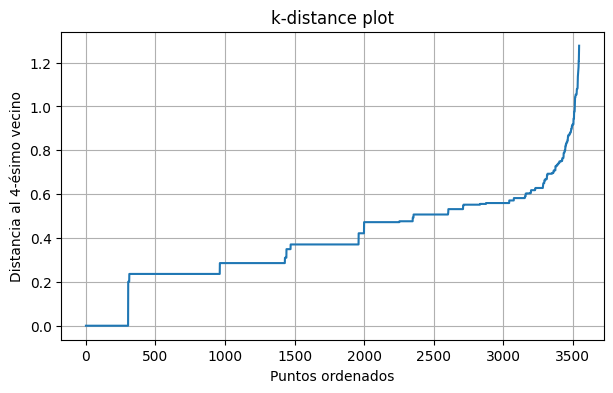

In [22]:
plt.figure(figsize=(7,4))
plt.plot(k_dist)
plt.xlabel("Puntos ordenados")
plt.ylabel(f"Distancia al {k}-ésimo vecino")
plt.title("k-distance plot")
plt.grid(True)
plt.show()

Se puede observar que a partir de apróximadamente el 0.5 la distancia empieza a subir exponencialmente, por lo que podemos definir a `eps` está aproximadamente en 0.5 y 0.6; después de gráficar se ajustó el valor a donde el número de clusters bajó radicalmente desde 262 en 0.5 a 51 en 0.63.

In [137]:
eps = 0.63

## DBSCAN

In [138]:
dbscan = DBSCAN(eps=eps, min_samples=k)
labels = dbscan.fit_predict(X_scaled)

In [139]:
df["dbscan_labels"] = labels
df.head()

,Date,hour_of_day,cash_type,money,coffee_ordered,Time_of_Day,Weekdaysort,Monthsort,Time,dbscan_labels
0,2024-03-01,10,1,38.7,3,0,5,3,10:15:50.520000,0
1,2024-03-01,12,1,38.7,8,1,5,3,12:19:22.539000,1
2,2024-03-01,12,1,38.7,8,1,5,3,12:20:18.089000,1
3,2024-03-01,13,1,28.9,1,1,5,3,13:46:33.006000,2
4,2024-03-01,13,1,38.7,3,1,5,3,13:48:14.626000,2


In [140]:
unique, counts = np.unique(labels, return_counts=True)
cluster_summary = pd.DataFrame({"label": unique, "count": counts})
cluster_summary

,label,count
0,-1,122
1,0,728
2,1,7
3,2,650
4,3,774
5,4,103
6,5,9
7,6,43
8,7,41
9,8,14


In [131]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters

51

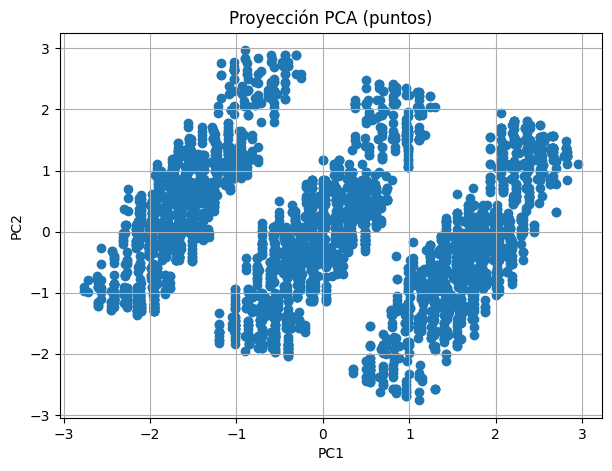

In [132]:
pca = PCA(n_components=2) # PCA para reducir las dimensiones y poder gráficar
proj = pca.fit_transform(X_scaled)
plt.figure(figsize=(7,5))
plt.scatter(proj[:,0], proj[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Proyección PCA (puntos)")
plt.grid(True)
plt.show()